<a href="https://colab.research.google.com/github/Ikhtiyor31/Deep-Learning/blob/master/Image_Classification_using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# helper libraries
import math 
import numpy as np
import matplotlib.pyplot as plt

#Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm
print(tf.__version__)

2.3.0


**Import the Fashion MNIST dataset**

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

In [35]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a training dataset and test dataset.
* The model is trained using train_dataset.
* The model is tested against test_dataset.


> The images are 28x28 arrays, with pixel values in the range(0, 255). The labels are an array of inegers, in range(0, 9). These correspond the class of clothing the images represents:






<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>








Each image is mapped to a single label. Since the class names are not included with the dataset, store the them here to use later when plotting the images.

In [36]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat'
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(class_names)
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))               

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'CoatSandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


**Explore data** -- The following shows there are 60,000 images in the training set, and 10,000 images in the test set.

In [37]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples: {}'.format(num_train_examples))
print('Number of test example: {}'.format(num_test_examples))

Number of training examples: 60000
Number of test example: 10000


**Preprocess the data**

The value of each pixel in the image data is an integer in the range [0, 255]. For the model to work properly, these values need to be normalized to the range [0, 1]. Here is to create a normalization function and then apply it to each image in the test and train datasets.

In [38]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

  # The map function applies the normalize function to each element in the train
  # and test datasets
  train_dataset = train_dataset.map(normalize)
  test_dataset = test_dataset.map(normalize)

In [39]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28, 28))  

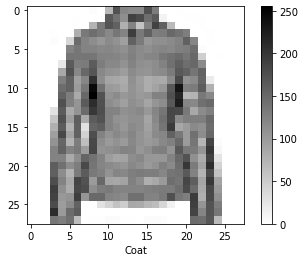

In [40]:
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[label])
plt.show()

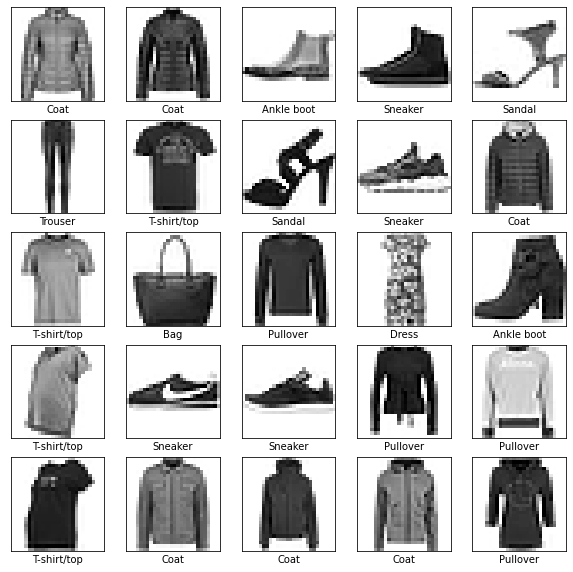

In [41]:
plt.figure(figsize=(10, 10))
i = 0
for image, label in test_dataset.take(25):
  image = image.numpy().reshape((28, 28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()  

**Building the model**

Building the neural network requires configuring the layers of the model, then compiling the model.

**Setup the layers**
* THe basic building block of a neural network is the layer. A layer extracts a representation from te data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.
> Much of deep learning consists of chaining together simple layers. Most layers, like **tf.keras.layers.Dense have internal parameters which are adjusted ("learned") during training. 


In [32]:
model = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(28,28, 1)),
     tf.keras.layers.Dense(128, activation=tf.nn.relu),
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)                        
])

In [76]:
print(len(model.layers))

7


This network has three layers: 
* **input** tf.keras.layers.Flatten -- This layer transforms the images from a 2d-array of 28 x 28 pixels to 1d-array of 784 pixels(28*28). Think of layer as unstacking rows of pixels in the image and lining them up. This layer has no parameteres to learn as it only reformats the data.
* **"hidden"** tf.keras.layers.Dense -- A densely connected layer of 126 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.
* **output** tf.keras.layers.Dense -- A 10-node softmax layer. EAch node represents a class of clothing. As the in the previous layer, each node takes input from the 128 nodes in the layer before it, weights thats input according to learned parameters, and outputs a value in the range [0, 1] representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

**Compile the model** -- Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
* *Loss function* -- An algorithm for measuring how far the model's output are from teh desired output. The goal of training is this measures loss.
* *Optimizer* -- An algorithm for adjusting the inner parameters of the model in order to minize loss.
* *Metrics* -- Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [42]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                                                    input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)                     
                             
])

In [56]:
print(len(model.layers))

9


In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

**Train the model**

1.   Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
2.   The dataset.shuffle(60,000) randomizes the order so our model cannot learn anything from the order of the examples.
3. And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.



In [44]:
batch_size = 32
train_dataset = train_dataset.repeat().shuffle(num_test_examples).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [45]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/batch_size))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5039 - accuracy: 0.8538
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2804 - accuracy: 0.8970
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2491 - accuracy: 0.9082
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2246 - accuracy: 0.9161
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1974 - accuracy: 0.9281
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1797 - accuracy: 0.9333
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1624 - accuracy: 0.9413
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1448 - accuracy: 0.9475
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1273 - accuracy: 0.9525
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.11

In [46]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/batch_size))

313/313 [==============================] - 1s 5ms/step - loss: 0.3627 - accuracy: 0.9118


In [47]:
print("Accuracy on test dataset: {}".format(test_accuracy))

Accuracy on test dataset: 0.9118000268936157


In [48]:
for image, label in test_dataset.take(1):
  test_images = image.numpy()
  test_labels = label.numpy()
  print(test_images.shape)
  predictions = model.predict(test_images)

(32, 28, 28, 1)


In [49]:
predictions.shape

(32, 10)

In [50]:
predictions[0]

array([4.1081908e-06, 3.4350677e-07, 4.5253627e-02, 6.2792467e-05,
       7.7277321e-01, 2.8225611e-07, 1.8190151e-01, 8.6918857e-07,
       2.8784189e-06, 3.8548421e-07], dtype=float32)

In [51]:
np.argmax(predictions[0])

4

In [52]:
test_labels[0]

4

In [53]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_labels, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_labels:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                       100 * np.argmax(predictions_array),
                                       class_names[true_labels]),
             color=color)  
    

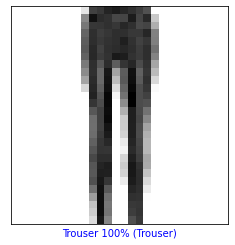

In [54]:
plot_image(5, predictions, test_labels,test_images)


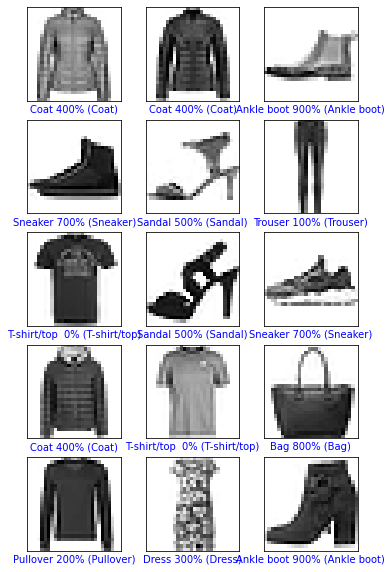

In [55]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i + 1)
  plot_image(i, predictions, test_labels, test_images)



**Accuracy improvements with CNN on Image classification**

**model** has 9 layers in total with applied CNN